# Theory
VRP : https://developers.google.com/optimization/routing/vrp \
CVRP : https://developers.google.com/optimization/routing/cvrp#python

In [1]:
import os
import networkx as nx
import numpy as np
import igraph as ig

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import random

from scripts.cvrp import TestCVRP
from scripts import graph_osm_loader, utils, clustering

from scripts.graph_filtration.utils import plot_simplex
from scripts.utils import cut_subgraph


print(f'This machine has {os.cpu_count()} cores')

# CVRP params
n_jobs = 16
time_limit = 10
n_runs = 30

This machine has 32 cores


# Full graph

Text(0.5, 1.0, '3343 nodes')

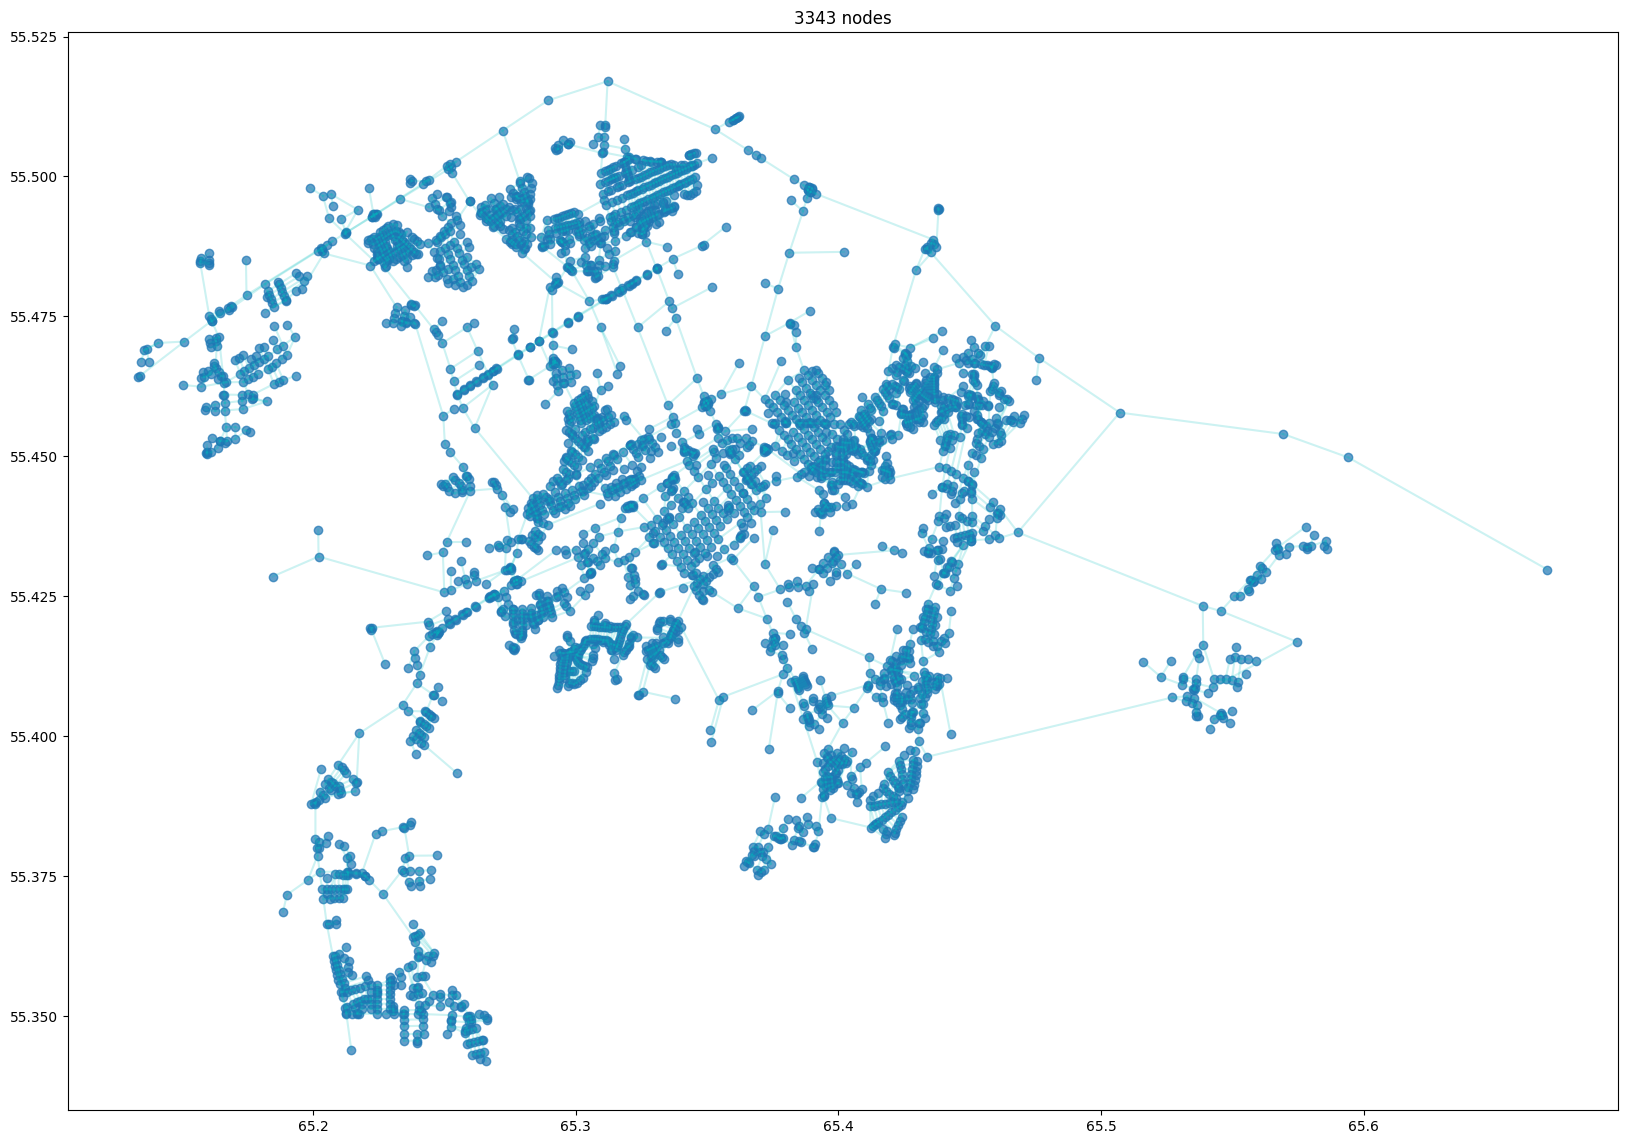

In [2]:
np.random.seed(0)
random.seed(0)


CITY = 'KRG'
GRAPH_ID = graph_osm_loader.cities[CITY] # KRG

# примеры id есть в graph_osm_loader.py
G = graph_osm_loader.get_graph(GRAPH_ID) # загрузка графа

pos = {u: [d['x'], d['y']] for u,d in G.nodes(data=True)} 

A = nx.adjacency_matrix(G, weight='length').todense()


K = [
        list(G.nodes), # dim = 0 : vertices
        list(G.edges), # dim = 1 : edges
    ]

plt.figure(figsize=(20, 14))
plot_simplex(pos, K)


plt.title(f'{len(G.nodes)} nodes')

In [3]:
from sklearn.metrics import silhouette_score


g = ig.Graph.from_networkx(G)
d_matrix = np.array(g.distances(weights='length'))
id_to_order = {id : order for order, id in enumerate(G.nodes)}

def silhouette(d_matrix, clusters):
    labels = np.zeros(len(id_to_order), dtype=int)

    for i, cluster in enumerate(clusters):
        for v in cluster:
            labels[id_to_order[v]] = i
    
    return silhouette_score(d_matrix, labels, metric='precomputed')

  0%|          | 0/1090 [00:00<?, ?it/s]

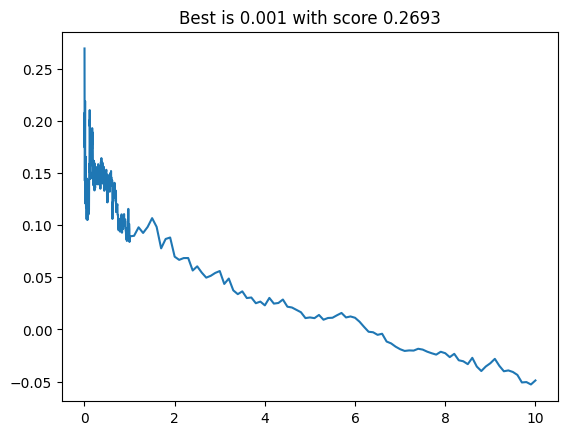

  0%|          | 0/7 [00:00<?, ?it/s]

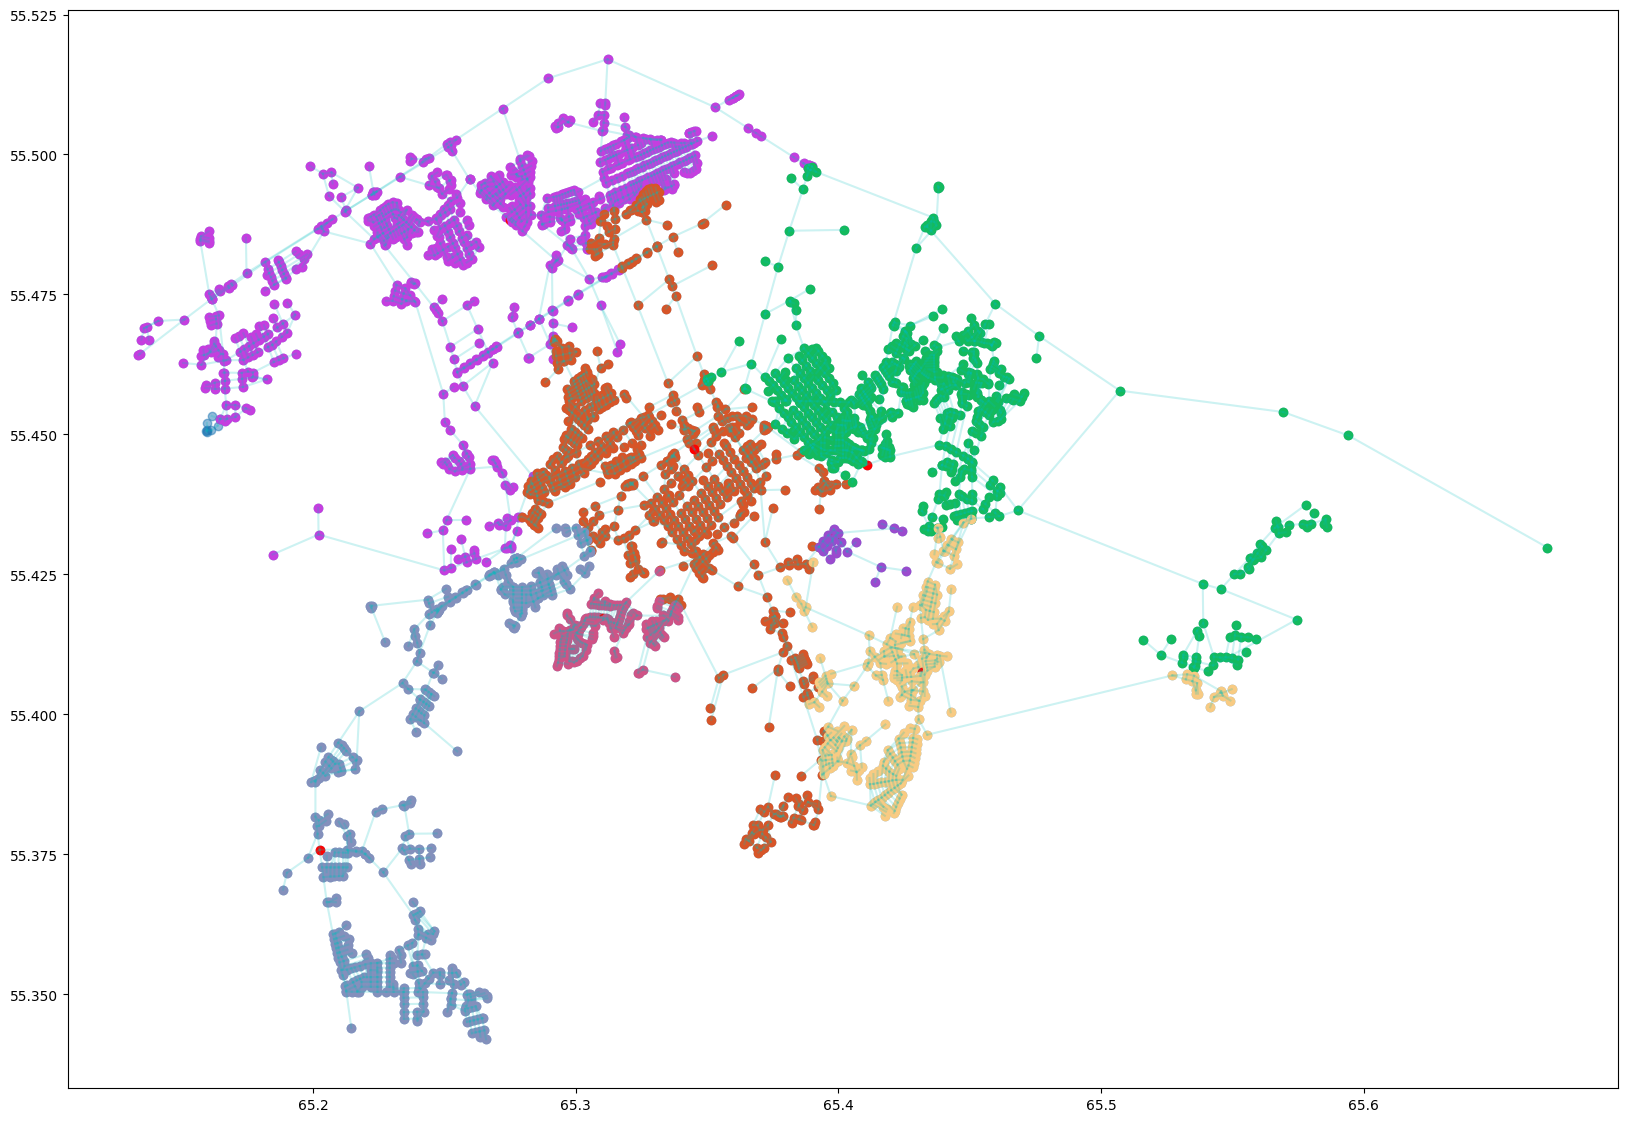

In [4]:
from random import randint
import leidenalg as la

# communities = clustering.leiden(G, partition_type=la.CPMVertexPartition, resolution_parameter = 0.05, weights='length', seed=0)

seed = 0
communities_sets = []
leiden_scores = []
resolutions = [0.001 * i for i in range(1, 1001)] + [0.1 * i for i in range(11, 101)]

for i in tqdm(resolutions):
    communities = clustering.leiden(G, partition_type=la.CPMVertexPartition, resolution_parameter = i, seed=seed, weights='length')
    communities_sets.append(communities)
    leiden_scores.append(silhouette(d_matrix, communities))
id = np.argmax(leiden_scores)

plt.plot(resolutions, leiden_scores)
plt.title(f'Best is {resolutions[id]} with score {leiden_scores[id]:.4f}')
plt.show()

communities = communities_sets[id]
communities = [c for c in communities if len(c) >= 10]

# Set the hubs
hubs = []

for cluster in communities:
    G_cluster = G.subgraph(cluster)
    hubs.append(nx.barycenter(G_cluster, weight='length')[0])

plt.figure(figsize=(20, 14))

plot_simplex(pos, K, alpha=0.5)
for j, cluster in enumerate(tqdm(communities)):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        if v in hubs:
            plt.scatter(point[0], point[1], c='red')
        else:
            plt.scatter(point[0], point[1], c=color)

In [5]:
# Max number of delivery points
sample_size = 10
N = sample_size #max([len(c) for c in communities])
# Number of vehicles
P = 2
# max delivery steps
max_steps = N #int(N / P * 1.5)

print(f'{len(communities)} communities: {[len(c) for c in communities]}')
print(f'N: {N}, max_steps: {max_steps}, max_steps * P = {max_steps * P}')

7 communities: [878, 765, 720, 436, 337, 176, 23]
N: 10, max_steps: 10, max_steps * P = 20


In [6]:
cvrp_task = TestCVRP(G, max_steps=max_steps, n_vehicles=P, time_limit=time_limit, weight='length', num_workers=n_jobs)

# cvrp_task.generate_demand()
# total, results = cvrp_task.test_cluster(communities, hubs, subset_size=sample_size)
results = cvrp_task.run_tests(communities, hubs, n_runs=n_runs, subset_size=sample_size)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
results

182928.26400000008

# Subgraph

Text(0.5, 1.0, '1000 nodes')

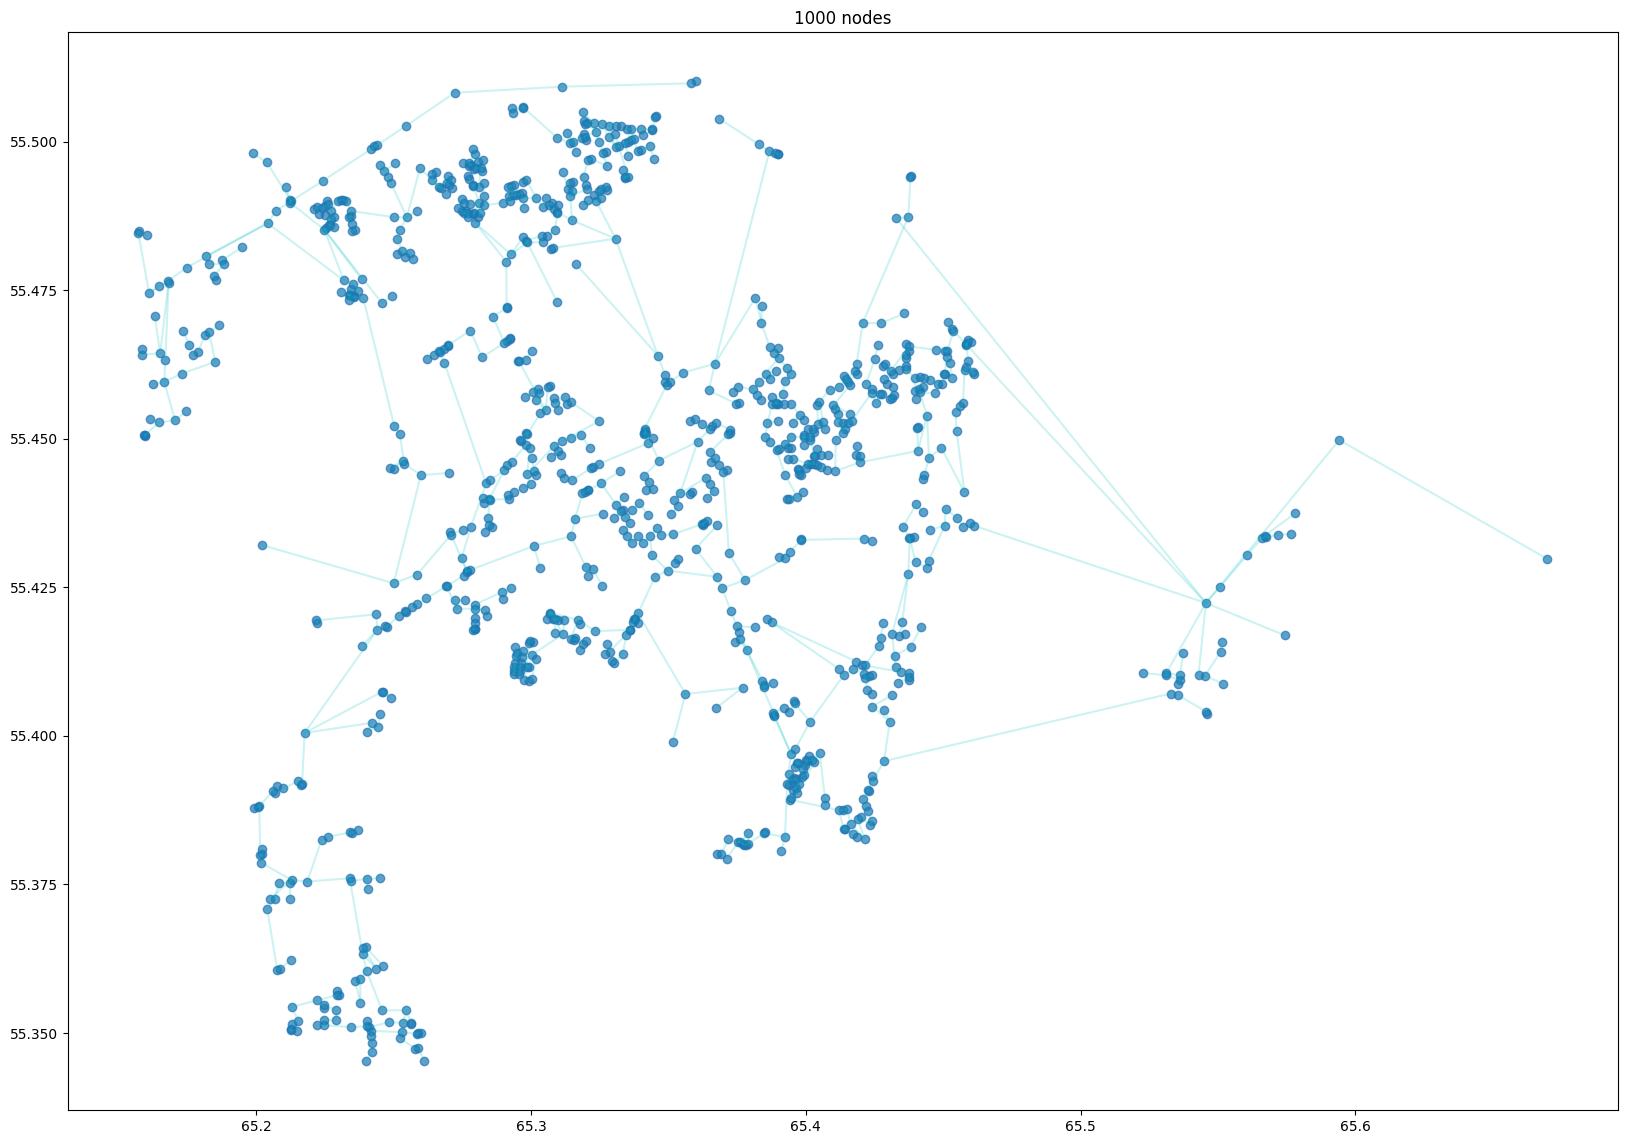

In [8]:
np.random.seed(0)
random.seed(0)

G = cut_subgraph(G, 1000, 'length')

pos = {u: [d['x'], d['y']] for u,d in G.nodes(data=True)} 

A = nx.adjacency_matrix(G, weight='length').todense()


K = [
        list(G.nodes), # dim = 0 : vertices
        list(G.edges), # dim = 1 : edges
    ]

plt.figure(figsize=(20, 14))
plot_simplex(pos, K)


plt.title(f'{len(G.nodes)} nodes')

In [9]:
g = ig.Graph.from_networkx(G)
d_matrix = np.array(g.distances(weights='length'))
id_to_order = {id : order for order, id in enumerate(G.nodes)}


def silhouette(d_matrix, clusters):
    labels = np.zeros(len(id_to_order), dtype=int)

    for i, cluster in enumerate(clusters):
        for v in cluster:
            labels[id_to_order[v]] = i
    
    return silhouette_score(d_matrix, labels, metric='precomputed')

  0%|          | 0/1090 [00:00<?, ?it/s]

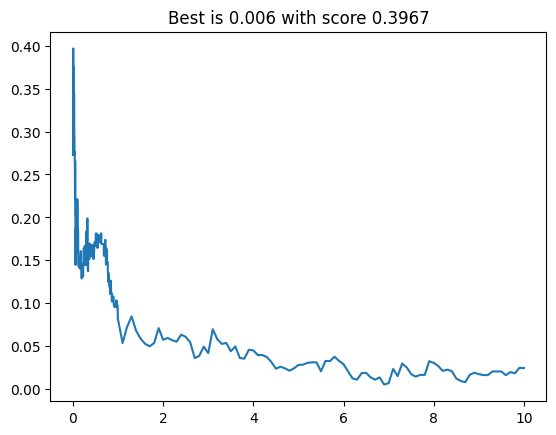

  0%|          | 0/9 [00:00<?, ?it/s]

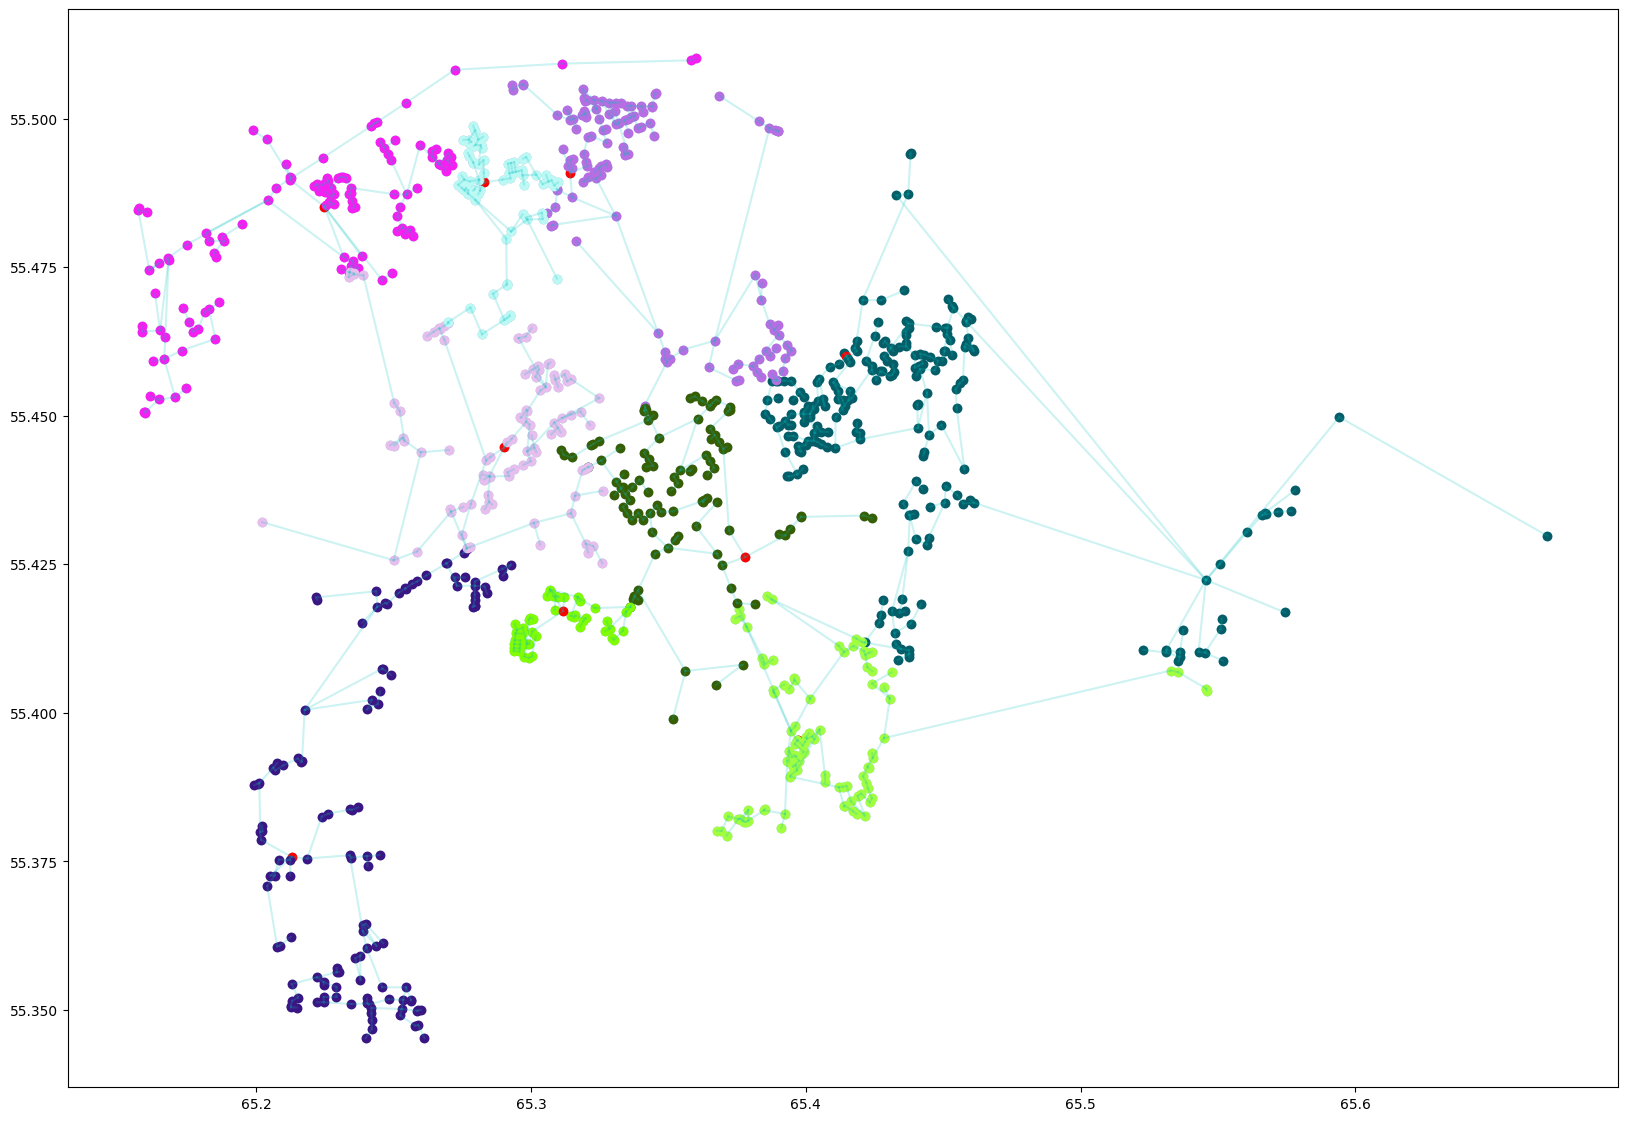

In [10]:
from random import sample
import leidenalg as la

# communities = clustering.leiden(G, partition_type=la.CPMVertexPartition, resolution_parameter = 0.05, weights='length', seed=0)

seed = 0
communities_sets = []
leiden_scores = []
resolutions = [0.001 * i for i in range(1, 1001)] + [0.1 * i for i in range(11, 101)]
for i in tqdm(resolutions):
    communities = clustering.leiden(G, partition_type=la.CPMVertexPartition, resolution_parameter = i, seed=seed, weights='length')
    communities_sets.append(communities)
    leiden_scores.append(silhouette(d_matrix, communities))
id = np.argmax(leiden_scores)

plt.plot(resolutions, leiden_scores)
plt.title(f'Best is {resolutions[id]} with score {leiden_scores[id]:.4f}')
plt.show()

communities = communities_sets[id]
communities = [c for c in communities if len(c) >= 10]

# Set the hubs
hubs = []

for cluster in communities:
    G_cluster = G.subgraph(cluster)
    hubs.append(nx.barycenter(G_cluster, weight='length')[0])

plt.figure(figsize=(20, 14))

plot_simplex(pos, K, alpha=0.5)
for j, cluster in enumerate(tqdm(communities)):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        if v in hubs:
            plt.scatter(point[0], point[1], c='red')
        else:
            plt.scatter(point[0], point[1], c=color)

In [11]:
# Max number of delivery points
sample_size = 10
N = sample_size #max([len(c) for c in communities])
# Number of vehicles
P = 2
# max delivery steps
max_steps = N #int(N / P * 1.5)

print(f'{len(communities)} communities: {[len(c) for c in communities]}')
print(f'N: {N}, max_steps: {max_steps}, max_steps * P = {max_steps * P}')

9 communities: [216, 124, 120, 117, 102, 100, 98, 74, 49]
N: 10, max_steps: 10, max_steps * P = 20


In [12]:

cvrp_task = TestCVRP(G, max_steps=max_steps, n_vehicles=P, time_limit=time_limit, weight='length', num_workers=n_jobs)

# cvrp_task.generate_demand()
# total, results = cvrp_task.test_cluster(communities, hubs, subset_size=sample_size)
results = cvrp_task.run_tests(communities, hubs, n_runs=n_runs, subset_size=sample_size)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [13]:
results

411951.0879999999